# Stock Analysis Using LSTM - MVP (LATEST)
- train an LSTM on a variable number of features
- vary on lookback (LSTM window) and training window (years before present date)
- multi input version
- multi day lookahead (predict x days ahead) version

This notebook adapted from https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm

# Import required libraries and set up notebook


In [1308]:
! pip install quandl
#! pip install yahoo_fin
import pandas as pd
import numpy as np
import os
import yaml
from datetime import date
import requests

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# import yahoo_fin.stock_info as si

# For time stamps
from datetime import datetime

# for LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.models import Model
# from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
# access datasets from quandl.com - need to pip install Quandl to use
import quandl
on_colab = False
verboseout = True
look_back = 3
config_file = 'model_training_config.yml'

You are using pip version 19.0.3, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1309]:
'''
r = requests.get('https://finnhub.io/api/v1/stock/dividend2?symbol=AAPL&token=c16hj0f48v6ppg7erf7g')
print(r.json())
'''

"\nr = requests.get('https://finnhub.io/api/v1/stock/dividend2?symbol=AAPL&token=c16hj0f48v6ppg7erf7g')\nprint(r.json())\n"

In [1310]:
start_timestamp = datetime.now()
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [1311]:
if on_colab:
    %cd /content/drive/MyDrive/karma_jan_2021/stock_investigation/notebooks

# Load config parameters

In [1312]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, config_file)
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')

current directory is: C:\personal\karma_stocks_2021\stock_investigation\notebooks
path_to_yaml C:\personal\karma_stocks_2021\stock_investigation\notebooks\model_training_config.yml


In [1313]:
# switches
plot_all = config['general']['verboseout']
use_saved_model = config['general']['presaved']
ust_cols = config['general']['ust_cols']
report_round = config['general']['report_round']
# list of ticket symbols
# e.g. tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
tech_list = config['tech_list']
# dictionary to seed stock handles with company names
# e.g. company_dict = {'AAPL':"APPLE", 'GOOG':"GOOGLE", 'MSFT':"MICROSOFT", 'AMZN':"AMAZON"}
company_dict = config['company_dict']
saved_model_modifier = config['files']['saved_model_modifier']
# get the column lists
continuouscols = config['categorical']
textcols = config['text']
collist = config['continuous']
close_threshold = config['general']['close_threshold']
years_window = config['general']['years_window']
quandl_token = config['general']['quandl_token']
# number of days previous used to predict subsequent day
look_back = config['general']['look_back']
# gap in day betwen the last day previous and the subsequent day being predicted
look_ahead = config['general']['look_ahead']
years_winow = config['general']['years_window']
# target column
lstm_target = config['general']['lstm_target']
# list from target column
lstm_target_list = [lstm_target]
# additional features beyond the target column
feature_list = config['general']['feature_list']
# complete list of features LSTM trained on
lstm_feature_list = lstm_target_list+feature_list
# switch to determine normalization method
min_max_norm = config['general']['min_max_norm']
eod_token = config['general']['eod_token']
sector_ticker = config['files']['sector_ticker']
debug_on = config['general']['debug_on']

In [1314]:
config

{'general': {'verboseout': False,
  'includetext': True,
  'on_colab': False,
  'debug_on': False,
  'presaved': False,
  'savemodel': False,
  'picklemodel': True,
  'save_model_plot': False,
  'tensorboard_callback': False,
  'hctextmax': 7000,
  'maxwords': 6000,
  'textmax': 50,
  'pickled_data_file': '20142018_0930.pkl',
  'pickled_dataframe': 'AB_NYC_2019_output_aug19_2020.pkl',
  'modifier': 'oct05_2020',
  'targetthresh': 6.0,
  'targetcontinuous': False,
  'target_col': 'price',
  'emptythresh': 6000,
  'zero_weight': 1.0,
  'one_weight': 45.878,
  'one_weight_offset': 0,
  'patience_threshold': 3,
  'min_max_norm': True,
  'master_start': '2018-01-01',
  'close_threshold': 0.01,
  'report_round': 4,
  'ust_cols': ['2 YR'],
  'years_window': 2,
  'quandl_token': 'uCghYBw8CtpUvWct_W8c',
  'finnhumb_key': 'c16hj0f48v6ppg7erf7g',
  'eod_token': 'OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX',
  'look_back': 3,
  'look_ahead': 7,
  'lstm_target': 'Close',
  'feature_list': ['2 YR',
   '30 YR',

# Ingest Sector Ticker file
- ingest CSV file that contains correlation between stock ticker symbols and ETF tickers as a proxy for sector tickers

In [1315]:
def get_data_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'data'))
    return(path)

In [1316]:
sector_file = os.path.join(get_data_path(),sector_ticker)
print("sector_file: ",sector_file)
df_sector = pd.read_csv(sector_file,encoding = "ISO-8859-1")
df_sector.head()

sector_file:  C:\personal\karma_stocks_2021\stock_investigation\data\sector_ticker.csv


,Symbol,Name,Sector,Sector Ticker,Sector ETF Ticker,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,A,Agilent Technologies Inc,Health Care,^SP500-35,IYH,NaN,- 'A',NaN,NaN,NaN,NaN
1,AAL,American Airlines Group,Industrials,^SP500-20,IYJ,NaN,- 'AAL',NaN,NaN,NaN,NaN
2,AAP,Advance Auto Parts,Consumer Discretionary,^SP500-25,XLY,NaN,- 'AAP',NaN,NaN,NaN,NaN
3,AAPL,Apple Inc.,Information Technology,^SP500-45,IYW,NaN,- 'AAPL',NaN,NaN,NaN,NaN
4,ABBV,AbbVie Inc.,Health Care,^SP500-35,IYH,NaN,- 'ABBV',NaN,NaN,NaN,NaN


# Experiment getting Sector value from Yahoo API
- set company to stock ticker
- set start and end to define timeframe

In [1317]:
end = datetime.now()
#end = datetime(end.year, end.month, end.day-7)
start = datetime(end.year - years_window, end.month, end.day)
company = 'IYE'
df_test = DataReader(company,data_source='yahoo', start=start, end=datetime.now())
print("start is: ",str(start))
print("end is: ",str(end))
df_test.head(10)

start is:  2019-03-25 00:00:00
end is:  2021-03-25 22:45:51.842557


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-25,35.700001,35.290001,35.459999,35.650002,1018800.0,31.876593
2019-03-26,36.410000,35.939999,35.990002,36.139999,708800.0,32.314735
2019-03-27,36.279999,35.619999,36.119999,35.889999,889000.0,32.091190
2019-03-28,36.080002,35.730000,35.730000,36.049999,673700.0,32.234257
2019-03-29,36.459999,35.900002,36.369999,36.029999,643900.0,32.216373
2019-04-01,36.549999,36.220001,36.220001,36.500000,553000.0,32.636627
2019-04-02,36.610001,36.150002,36.540001,36.250000,567500.0,32.413090
2019-04-03,36.389999,35.730000,36.310001,35.849998,742700.0,32.055428
2019-04-04,36.189999,35.720001,35.869999,36.160000,756300.0,32.332615


# Experiment with EOD API for dividend
- EOD historical data doesn't directly support Python access
- https://eodhistoricaldata.com/financial-apis/python-example/




In [1318]:
import requests

import pandas as pd

from io import StringIO

# URL for dividend data
# https://eodhistoricaldata.com/api/div/AAPL.US?api_token=OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX&from=2000-01-01

def get_div_data(symbol='AAPL.US', api_token='OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX', session=None):
    if session is None:
        session = requests.Session()
    url = 'https://eodhistoricaldata.com/api/div/%s' % symbol
    params = {'api_token': api_token}
    r = session.get(url, params=params)
    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=1, parse_dates=[0], index_col=0, engine='python')
        return(True, df)
    else:
        print("status code",str(r.status_code))
        print("reason code",str(r.reason))
        return(False,"null")
        #raise Exception(r.status_code, r.reason, url)

In [1319]:
#dividend_exists, df_eod = get_div_data('IBM',eod_token)

In [1320]:
'''
if dividend_exists:
    print(df_eod.head())
else:
    print('no dividend')
'''

"\nif dividend_exists:\n    print(df_eod.head())\nelse:\n    print('no dividend')\n"

In [1321]:
# df_eod.head()

# Load US Treasury stats

In [1322]:
# load US Treasury yield dataframe
ust_df = quandl.get("USTREASURY/YIELD", authtoken=quandl_token)

In [1323]:
ust_df

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-19,0.01,0.01,0.01,0.03,0.07,0.16,0.33,0.90,1.38,1.74,2.36,2.45
2021-03-22,0.02,0.02,0.03,0.05,0.06,0.15,0.32,0.87,1.34,1.69,2.29,2.38
2021-03-23,0.02,0.02,0.01,0.04,0.08,0.15,0.31,0.83,1.29,1.63,2.24,2.34


In [1324]:
# new = old[['A', 'C', 'D']].copy()
ust_df_2year = ust_df[['2 YR']].copy()
ust_df_2year.head()

,2 YR
Date,
1990-01-02,7.87
1990-01-03,7.94
1990-01-04,7.92
1990-01-05,7.90
1990-01-08,7.90


# Load consumer sentiment


In [1325]:
# from https://www.quandl.com/data/UMICH/SOC22-University-of-Michigan-Consumer-Survey-Current-Market-Value-of-Primary-Residence
# ust_df = quandl.get("USTREASURY/YIELD", authtoken=quandl_token)
# authtoken=quandl_token
conf_df = quandl.get("UMICH/SOC22", authtoken=quandl_token)

In [1326]:
conf_df.head()

,Under $100_000,$100_000 - $199_999,$200_000 - $299_999,$300_000 - $399_999,$400_000 - $499_999,$500_000 +,DK; NA,25th Percentile,Median,75th Percentile,Interquartile Range (75th-25th)
Date,,,,,,,,,,,
1990-08-31,60.0,23.0,10.0,1.0,0.0,1.0,5.0,41521.0,75457.0,124447.0,82926.0
1993-11-30,54.0,27.0,7.0,3.0,1.0,3.0,5.0,44000.0,82333.0,149820.0,105820.0
1993-12-31,53.0,28.0,9.0,2.0,1.0,1.0,6.0,50514.0,83693.0,150990.0,100476.0
1994-01-31,57.0,21.0,9.0,4.0,0.0,1.0,8.0,49963.0,80484.0,132046.0,82083.0
1994-02-28,55.0,29.0,7.0,2.0,2.0,2.0,3.0,56000.0,86300.0,148333.0,92333.0


In [1327]:
conf_df.tail()

,Under $100_000,$100_000 - $199_999,$200_000 - $299_999,$300_000 - $399_999,$400_000 - $499_999,$500_000 +,DK; NA,25th Percentile,Median,75th Percentile,Interquartile Range (75th-25th)
Date,,,,,,,,,,,
2020-09-30,8.0,19.0,20.0,15.0,9.0,24.0,5.0,176594.0,295738.0,495580.0,318987.0
2020-10-31,8.0,20.0,17.0,16.0,11.0,23.0,5.0,175380.0,300500.0,477137.0,301757.0
2020-11-30,8.0,15.0,21.0,15.0,9.0,26.0,6.0,198333.0,302360.0,501011.0,302677.0
2020-12-31,10.0,17.0,22.0,18.0,9.0,21.0,3.0,180926.0,289556.0,440000.0,259074.0
2021-01-31,8.0,18.0,18.0,17.0,10.0,23.0,6.0,181345.0,300875.0,473333.0,291989.0


In [1328]:
conf_df.shape

(202, 11)

# Parameters to incorporate
- Investor sentiment: https://www.quandl.com/data/AAII/AAII_SENTIMENT-AAII-Investor-Sentiment-Data
- GDP: https://www.quandl.com/data/FRED/GDP-Gross-Domestic-Product
- Consumer Price Index (as proxy for inflation): https://www.quandl.com/data/FRED/CPIAUCSL-Consumer-Price-Index-for-All-Urban-Consumers-All-Items (I think these figures are derived from the same source I put in the factor spreadsheet: https://www.bls.gov/news.release/cpi.toc.htm)
- Civilian unemployment rate: https://www.quandl.com/data/FRED/UNRATE-Civilian-Unemployment-Rate

# Load investor sentiment

In [1329]:
# investor sentiment
# https://www.quandl.com/data/AAII/AAII_SENTIMENT-AAII-Investor-Sentiment-Data
# weekly
inv_sent_df = quandl.get("AAII/AAII_SENTIMENT", authtoken=quandl_token)
inv_sent_df.head()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
1987-06-26,NaN,NaN,NaN,NaN,NaN,NaN,0.379845,0.480336,0.279354,NaN,NaN,NaN
1987-07-17,NaN,NaN,NaN,NaN,NaN,NaN,0.379845,0.480336,0.279354,314.59,307.63,314.59
1987-07-24,0.36,0.50,0.14,1.0,NaN,0.22,0.379845,0.480336,0.279354,311.39,307.81,309.27
1987-07-31,0.26,0.48,0.26,1.0,NaN,0.00,0.379845,0.480336,0.279354,318.66,310.65,318.66
1987-08-07,0.56,0.15,0.29,1.0,NaN,0.27,0.379845,0.480336,0.279354,323.00,316.23,323.00


In [1330]:
inv_sent_df.tail()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
2021-02-18,0.470588,0.275542,0.253870,1.0,0.441332,0.216718,0.379845,0.480336,0.279354,3950.43,3884.94,3931.33
2021-02-25,0.459283,0.302932,0.237785,1.0,0.442828,0.221498,0.379845,0.480336,0.279354,3924.30,3911.13,3924.30
2021-03-04,0.402597,0.344156,0.253247,1.0,0.439733,0.149350,0.379845,0.480336,0.279354,3837.96,3817.26,3837.20
2021-03-11,0.494118,0.270588,0.235294,1.0,0.443618,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81
2021-03-18,0.489437,0.274648,0.235915,1.0,0.443527,0.253522,0.379845,0.480336,0.279354,3953.50,3947.41,3952.17


In [1331]:
inv_sent_df.shape

(1757, 12)

In [1332]:
inv_sent_df.index

DatetimeIndex(['1987-06-26', '1987-07-17', '1987-07-24', '1987-07-31',
               '1987-08-07', '1987-08-14', '1987-08-21', '1987-08-28',
               '1987-09-04', '1987-09-11',
               ...
               '2021-01-07', '2021-01-21', '2021-01-28', '2021-02-04',
               '2021-02-11', '2021-02-18', '2021-02-25', '2021-03-04',
               '2021-03-11', '2021-03-18'],
              dtype='datetime64[ns]', name='Date', length=1757, freq=None)

In [1333]:
# infill weekly time series to daily
# try  resample approach: https://stackoverflow.com/questions/55901304/pandas-resample-from-weekly-to-daily-with-offset
# df = df.resample('D', loffset=offset).ffill()
inv_sent_df2 = inv_sent_df.resample('D').ffill()

inv_sent_df2

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
1987-06-26,NaN,NaN,NaN,NaN,NaN,NaN,0.379845,0.480336,0.279354,NaN,NaN,NaN
1987-06-27,NaN,NaN,NaN,NaN,NaN,NaN,0.379845,0.480336,0.279354,NaN,NaN,NaN
1987-06-28,NaN,NaN,NaN,NaN,NaN,NaN,0.379845,0.480336,0.279354,NaN,NaN,NaN
1987-06-29,NaN,NaN,NaN,NaN,NaN,NaN,0.379845,0.480336,0.279354,NaN,NaN,NaN
1987-06-30,NaN,NaN,NaN,NaN,NaN,NaN,0.379845,0.480336,0.279354,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-14,0.494118,0.270588,0.235294,1.0,0.443618,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81
2021-03-15,0.494118,0.270588,0.235294,1.0,0.443618,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81
2021-03-16,0.494118,0.270588,0.235294,1.0,0.443618,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81


In [1334]:

ust_df.shape

(7813, 12)

# Load GDP

In [1335]:
gdp_df = quandl.get("FRED/GDP", authtoken=quandl_token)
gdp_df.tail()

,Value
Date,
2019-10-01,21747.394
2020-01-01,21561.139
2020-04-01,19520.114
2020-07-01,21170.252
2020-10-01,21494.731


In [1336]:
gdp_df.rename(columns={'Value':'gdp'}, inplace=True)
gdp_df.tail()

,gdp
Date,
2019-10-01,21747.394
2020-01-01,21561.139
2020-04-01,19520.114
2020-07-01,21170.252
2020-10-01,21494.731


In [1337]:
# bring the series up to today
add_date = np.datetime64(date.today())
add_date

numpy.datetime64('2021-03-25')

In [1338]:
gdp_df.loc[add_date] = [21487.896]

In [1339]:
gdp_df = gdp_df.resample('D').ffill()
gdp_df.tail()

,gdp
Date,
2021-03-21,21494.731
2021-03-22,21494.731
2021-03-23,21494.731
2021-03-24,21494.731
2021-03-25,21487.896


# Load CPI

In [1340]:
cpi_df = quandl.get("FRED/CPIAUCSL", authtoken=quandl_token)
cpi_df.tail()

,Value
Date,
2020-10-01,260.462
2020-11-01,260.927
2020-12-01,261.560
2021-01-01,262.231
2021-02-01,263.161


In [1341]:
cpi_df.rename(columns={'Value':'cpi'}, inplace=True)

In [1342]:
# bring the series up to today
add_date = np.datetime64(date.today())
add_date

numpy.datetime64('2021-03-25')

In [1343]:
cpi_df.loc[add_date] = [262.231]

In [1344]:
cpi_df = cpi_df.resample('D').ffill()
cpi_df.tail()

,cpi
Date,
2021-03-21,263.161
2021-03-22,263.161
2021-03-23,263.161
2021-03-24,263.161
2021-03-25,262.231


# Load unemployment

In [1345]:
# Civilian unemployment rate: https://www.quandl.com/data/FRED/UNRATE-Civilian-Unemployment-Rate
# monthly
unemp_df = quandl.get("FRED/UNRATE")
unemp_df.tail()

,Value
Date,
2020-10-01,6.9
2020-11-01,6.7
2020-12-01,6.7
2021-01-01,6.3
2021-02-01,6.2


In [1346]:
unemp_df.rename(columns={'Value':'unemployment'}, inplace=True)

In [1347]:
unemp_df.index

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01'],
              dtype='datetime64[ns]', name='Date', length=878, freq=None)

In [1348]:
# bring the series up to today
add_date = np.datetime64(date.today())
add_date

numpy.datetime64('2021-03-25')

In [1349]:
unemp_df.loc[add_date] = [6.2]

In [1350]:
unemp_df.tail()

,unemployment
Date,
2020-11-01,6.7
2020-12-01,6.7
2021-01-01,6.3
2021-02-01,6.2
2021-03-25,6.2


In [1351]:
unemp_df = unemp_df.resample('D').ffill()
unemp_df.tail()

,unemployment
Date,
2021-03-21,6.2
2021-03-22,6.2
2021-03-23,6.2
2021-03-24,6.2
2021-03-25,6.2


In [1352]:
unemp_df.shape

(26748, 1)

# Load dividends
- source is Yahoo

In [1353]:
# this source is no good because it's a single entry, not a series
#quote_table = si.get_quote_table("aapl", dict_result=False)

In [1354]:
#quote_table

# Join input dataframes

In [1355]:
# do an inner join on Date column
ust_df = pd.merge(ust_df,inv_sent_df2,on=['Date'],how='inner')
ust_df.head() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,...,0.34,1.0,0.31250,0.01,0.379845,0.480336,0.279354,353.40,346.81,353.4
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,...,0.34,1.0,0.31250,0.01,0.379845,0.480336,0.279354,353.40,346.81,353.4
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,...,0.34,1.0,0.31250,0.01,0.379845,0.480336,0.279354,353.40,346.81,353.4
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,...,0.30,1.0,0.32875,0.10,0.379845,0.480336,0.279354,359.69,352.20,352.2
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,...,0.30,1.0,0.32875,0.10,0.379845,0.480336,0.279354,359.69,352.20,352.2


In [1356]:
ust_df = pd.merge(ust_df,unemp_df,on=['Date'],how='inner')
ust_df.tail() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-12,0.03,0.03,0.04,0.06,0.09,0.14,0.34,0.85,1.30,1.64,...,1.0,0.443618,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81,6.2
2021-03-15,0.02,0.02,0.04,0.06,0.08,0.14,0.33,0.84,1.28,1.62,...,1.0,0.443618,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81,6.2
2021-03-16,0.01,0.02,0.02,0.06,0.07,0.15,0.33,0.83,1.28,1.62,...,1.0,0.443618,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81,6.2
2021-03-17,0.01,0.02,0.02,0.05,0.07,0.13,0.29,0.80,1.27,1.63,...,1.0,0.443618,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81,6.2
2021-03-18,0.01,0.01,0.01,0.03,0.08,0.16,0.33,0.86,1.35,1.71,...,1.0,0.443527,0.253522,0.379845,0.480336,0.279354,3953.50,3947.41,3952.17,6.2


In [1357]:
ust_df = pd.merge(ust_df,gdp_df,on=['Date'],how='inner')
ust_df.head() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment,gdp
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,...,0.31250,0.01,0.379845,0.480336,0.279354,353.40,346.81,353.4,5.4,5872.701
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,...,0.31250,0.01,0.379845,0.480336,0.279354,353.40,346.81,353.4,5.4,5872.701
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,...,0.31250,0.01,0.379845,0.480336,0.279354,353.40,346.81,353.4,5.4,5872.701
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,...,0.32875,0.10,0.379845,0.480336,0.279354,359.69,352.20,352.2,5.4,5872.701
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,...,0.32875,0.10,0.379845,0.480336,0.279354,359.69,352.20,352.2,5.4,5872.701


In [1358]:
ust_df.tail()

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment,gdp
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-12,0.03,0.03,0.04,0.06,0.09,0.14,0.34,0.85,1.30,1.64,...,0.443618,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81,6.2,21494.731
2021-03-15,0.02,0.02,0.04,0.06,0.08,0.14,0.33,0.84,1.28,1.62,...,0.443618,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81,6.2,21494.731
2021-03-16,0.01,0.02,0.02,0.06,0.07,0.15,0.33,0.83,1.28,1.62,...,0.443618,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81,6.2,21494.731
2021-03-17,0.01,0.02,0.02,0.05,0.07,0.13,0.29,0.80,1.27,1.63,...,0.443618,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81,6.2,21494.731
2021-03-18,0.01,0.01,0.01,0.03,0.08,0.16,0.33,0.86,1.35,1.71,...,0.443527,0.253522,0.379845,0.480336,0.279354,3953.50,3947.41,3952.17,6.2,21494.731


In [1359]:
ust_df.shape

(7808, 26)

In [1360]:
ust_df = pd.merge(ust_df,cpi_df,on=['Date'],how='inner')
ust_df.tail() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment,gdp,cpi
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-12,0.03,0.03,0.04,0.06,0.09,0.14,0.34,0.85,1.30,1.64,...,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81,6.2,21494.731,263.161
2021-03-15,0.02,0.02,0.04,0.06,0.08,0.14,0.33,0.84,1.28,1.62,...,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81,6.2,21494.731,263.161
2021-03-16,0.01,0.02,0.02,0.06,0.07,0.15,0.33,0.83,1.28,1.62,...,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81,6.2,21494.731,263.161
2021-03-17,0.01,0.02,0.02,0.05,0.07,0.13,0.29,0.80,1.27,1.63,...,0.258824,0.379845,0.480336,0.279354,3917.35,3885.73,3898.81,6.2,21494.731,263.161
2021-03-18,0.01,0.01,0.01,0.03,0.08,0.16,0.33,0.86,1.35,1.71,...,0.253522,0.379845,0.480336,0.279354,3953.50,3947.41,3952.17,6.2,21494.731,263.161


# Define start and end of analysis period

In [1361]:
# DataReader: https://riptutorial.com/pandas/topic/1912/pandas-datareader
# https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
# 
# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - years_window, end.month, end.day)
tester = DataReader('AAPL', 'yahoo', start, end)
tester.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-25,47.994999,46.650002,47.877499,47.185001,175381200.0,46.217113
2019-03-26,48.220001,46.145000,47.915001,46.697498,199202000.0,45.739620
2019-03-27,47.439999,46.637501,47.187500,47.117500,119393600.0,46.151005
2019-03-28,47.389999,46.882500,47.237499,47.180000,83121600.0,46.212219
2019-03-29,47.520000,47.134998,47.457500,47.487499,94256000.0,46.513416


# Main model definition
- build dataframe containing all features
- define helper functions
- run main blocks to define and train model
- run block to visualize predictions

# Block to define main dataframe
- combine closing data dataframe with additional time series data (e.g. from quandl)

In [1362]:
#Get the stock quote
# tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
df_predict = {}
# list of bad tickerts
exception_list = []
for company in tech_list:
    try:
        df_predict[company] = DataReader(company,data_source='yahoo', start=start, end=datetime.now())
        print("feature_list is ",feature_list)
        temp_feature_list = feature_list.copy()
        if 'Sector_Close' in feature_list:
            # get the sector ETF ticker corresponding with the company ticker
            sector = df_sector.loc[df_sector['Symbol'] == company,'Sector ETF Ticker'].iloc[0]
            # call Yahoo API for the sector ETF ticker
            sector_df = DataReader(sector,data_source='yahoo', start=start, end=datetime.now())
            # rename to get Sector_Close
            sector_df.rename(columns = {'Close':'Sector_Close'}, inplace=True)
            temp_feature_list.remove('Sector_Close')
        df_predict[company]['Return'] = df_predict[company]['Close']/df_predict[company]['Close'].shift() -1
        df_predict[company]['Return'] = df_predict[company]['Return'].fillna(0.0)
        # check if anything being joined
        if len(feature_list) > 0:
            print("temp_feature_list is ",temp_feature_list)
            df_predict[company] = pd.merge(df_predict[company],ust_df[temp_feature_list],on=['Date'],how='inner')
            if 'Sector_Close' in feature_list:
                df_predict[company] = pd.merge(df_predict[company],sector_df['Sector_Close'],on=['Date'],how='inner')
    except Exception as e:
        if debug_on:
            raise
        print("exception generated "+str(e)+" attempting ticker "+company)
        # add to list of bad tickers
        exception_list.append(company)
    else:
        print("exception not generated")
        print("sector is: ",sector)
# remove bad tickers
tech_list = [i for i in tech_list if i not in exception_list]
print("revised tech_list is: ",tech_list)
df_predict[tech_list[0]].head()

feature_list is  ['2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi', 'Sector_Close']
temp_feature_list is  ['2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi']
exception not generated
sector is:  IYF
feature_list is  ['2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi', 'Sector_Close']
exception generated single positional indexer is out-of-bounds attempting ticker SHAK
feature_list is  ['2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi', 'Sector_Close']
temp_feature_list is  ['2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi']
exception not generated
sector is:  IYJ
revised tech_list is:  ['BLK', 'CAT']


,High,Low,Open,Close,Volume,Adj Close,Return,2 YR,30 YR,Bullish,Bearish,unemployment,gdp,cpi,Sector_Close
Date,,,,,,,,,,,,,,,
2019-03-25,419.500000,413.299988,418.000000,415.410004,411000.0,393.745148,0.000000,2.26,2.87,0.373016,0.234127,3.8,21115.309,254.147,58.005001
2019-03-26,423.309998,418.940002,420.570007,422.670013,494900.0,400.626556,0.017477,2.24,2.86,0.373016,0.234127,3.8,21115.309,254.147,58.650002
2019-03-27,425.529999,417.709991,423.600006,419.640015,425000.0,397.754547,-0.007169,2.22,2.83,0.373016,0.234127,3.8,21115.309,254.147,58.455002
2019-03-28,425.640015,420.230011,421.399994,424.970001,342700.0,402.806549,0.012701,2.23,2.81,0.332000,0.272000,3.8,21115.309,254.147,58.930000
2019-03-29,432.000000,426.190002,429.709991,427.369995,455900.0,405.081390,0.005647,2.27,2.81,0.332000,0.272000,3.8,21115.309,254.147,59.064999


# Define helper functions
- define helper functions used by main model training block

In [1363]:
def get_model_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [1364]:
def save_model(model,company):
    '''save the model to a file in directory models that is a peer of the directory containing this notebook'''
    model_path = get_model_path()
    modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    model.save(save_model_path)
    # no early stop, so make current model saved_model
    print("Saved model with name ",company+modifier+'.h5')
    


In [1365]:
def get_save_model_path(company):
    model_path = get_model_path()
    modifier = saved_model_modifier
    # modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    return(save_model_path)

In [1366]:
def one_col_df(df,col):
    data = df.filter([col])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .8 ))
    return(data,dataset,training_data_len)

In [1367]:
def multi_col_df(df,cols):
    print("cols is:", cols)
    #data = df.filter(cols)
    data = df[cols]
    #print("data inside is:",data)
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .8 ))
    return(data,dataset,training_data_len)

In [1368]:
def get_keras_vars(dataset):
    '''cribbed from traditional DL on structured data code'''
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
       
    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))
        
    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
        
    return X, dictlist

In [1369]:
def scale_data(dataset):
    if min_max_norm:
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(dataset)
    else:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(dataset)
    return(scaled_data,scaler)

In [1370]:
def create_x_y(scaled_data,training_data_len,look_back,input_col_count):
    '''convert scaled dataset into numpy x and y arrays for training'''
    #Create the training data set
    #Create the scaled training data set
    print("scaled_data shape: ",str(scaled_data.shape))
    print('training_data_len: ',training_data_len)
    train_data = scaled_data[0:int(training_data_len), :]
    print("train_data shape is: ",train_data.shape)
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    print("len(train_data): ",str(len(train_data)))
    # here, each x is a set of look_back values and each y is the next value
    # a = dataset[i:(i + look_back), :]
    for i in range(len(train_data) - look_back - look_ahead - 1):
        a = train_data[i:(i + look_back), :]
        x_train.append(a)
        y_train.append(train_data[i+look_ahead, 0])
        

    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Reshape the data
    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape
    return(x_train,y_train)

In [1371]:
def build_model(x_train,y_train,optimizer,loss_function):
        '''build simple model given x, y, optimizer and loss function - sequential API'''
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer=optimizer, loss=loss_function)

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        return(model)

In [1372]:
def build_model_func(x_train,y_train,optimizer,loss_function,input_dim):
        '''build simple model given x, y, optimizer and loss function - functional API'''
        '''reference https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras
            and https://stackoverflow.com/questions/42532386/how-to-work-with-multiple-inputs-for-lstm-in-keras'''
        lstminputs = {}
        inputlayerlist = []
        col = "holder"
        #lstminputs[col] = Input(shape=(x_train.shape[1],1),name=col)
        lstminputs[col] = Input(shape=(x_train.shape[1],input_dim),name=col)
        inputlayerlist.append(lstminputs[col])
        lstminputs[col] = (LSTM(128,return_sequences=True) (lstminputs[col]))
        lstminputs[col] = (LSTM(64,return_sequences=False) (lstminputs[col]))
        lstminputs[col] = (Dense(25) (lstminputs[col]))
        
        #output = Dense(1, activation=output_activation) (lstminputs[col])
        output = Dense(1) (lstminputs[col])
        # define model

        model = Model(inputlayerlist, output)

        
        
 
        model.compile(optimizer=optimizer, loss=loss_function)

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        return(model)

In [1373]:
def build_model_func2(x_train,y_train,optimizer,loss_function,collist,continuouscols,lstmcols):
    '''build multi-input functional API model
    collist - list of categorical columns
    continuouscols - list of continuous columns
    
    want to have x_train being a list of numpy arrays, 
    one for each column that we want to create layers for
    
    
    
    '''
    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    lstminput = {} # list of lstm inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings
    inputlayerlist = []
    

    
    '''
    for col in lstmcols:
        lstminputs[col] = Input(shape=(x_train.shape[1],1),name=col)
        inputlayerlist.append(lstminputs[col])
        lstminputs[col] = (LSTM(128,return_sequences=True) (lstminputs[col]))
        lstminputs[col] = (LSTM(64,return_sequences=False) (lstminputs[col]))
        lstminputs[col] = (Dense(25) (lstminputs[col]))
        # question here whether to include a dense layer or not at the end of LSTM 
        '''
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
    for col in continuouscols:
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])
        
    return(model)

In [1374]:
# from https://stackoverflow.com/questions/53049396/sklearn-inverse-transform-return-only-one-column-when-fit-to-many
def invTransform(scaler, data, colName, colNames):
    # wrapper function to get inverse transform on one column from a dataframe that has been scaled
    # - scaler   = the scaler object (it needs an inverse_transform method)
    # - data     = the data to be inverse transformed as a Series, ndarray, ... 
    #              (a 1d object you can assign to a df column)
    # - ftName   = the name of the column to which the data belongs
    # - colNames = all column names of the data on which scaler was fit 
    #              (necessary because scaler will only accept a df of the same shape as the one it was fit on)
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [1375]:
def get_path():
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'output'))
    return(path)

# Main model definition and training block

In [1376]:
%%time
# train models for each company in tech_list and save trained models
predictions = {}
data = {}
for company in tech_list:
    data[company],dataset,training_data_len = multi_col_df(df_predict[company],lstm_feature_list)
    # X, dictlist get_keras_vars(df_predict[company])
    #print("dataset is: ",dataset)
    #print(("data[company] is:",data[company]))
    print("training_data_len: ",training_data_len)
    print("dataset shape: ",str(dataset.shape))
    print("data[company] shape: ",str(data[company].shape))
    #scaled_data, scaler = scale_data(dataset)
    scaled_data, scaler = scale_data(data[company])
    x_train, y_train = create_x_y(scaled_data,training_data_len,look_back,len(lstm_feature_list))
    #print("x_train is: ",x_train)
    #print("y_train is: ",y_train)
    print("x_train shape: ",x_train.shape)
    print("y_train shape: ",y_train.shape)
    print("TRAINING LOOP FOR: ",str(company))
    '''
    turn off for experiment with multi columns
    '''
    if use_saved_model:
        # put here
        save_model_path = get_save_model_path(company)
        model = load_model(save_model_path)
    else:
        # train model fresh
        #Build the LSTM model
        model = build_model_func(x_train,y_train,'adam','mean_squared_error',len(lstm_feature_list))
        # save the model
        save_model(model,company)
    #Create a new array containing scaled values from index 1543 to 2002 
    
    test_data = scaled_data[training_data_len - look_back: , :]
    #Create the data sets x_test and y_test
    print("about to run test loop")
    x_test = []
    y_test = []
    # y_test = dataset[training_data_len:, :]
    for i in range(len(test_data)-look_ahead):
        y_test.append(test_data[i+look_ahead, 0])
    
    
    
    print("look_back is", look_back)
    print("shape of test_data is ",str(test_data.shape))
    print("len(test_data) is ",len(test_data))
    for i in range(look_back,len(test_data)):
        a = test_data[i-look_back:i, :]
        x_test.append(a)
    print("shape of a is ",str(a.shape))
    print("after test loop")
    '''
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    '''
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    print("x_test shape",x_test.shape)
    print("y_test shape",y_test.shape)
    # Reshape the data
    #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Get the models predicted price values 
    predictions_temp = model.predict(x_test)
    print("after predictions_temp")
    print("predictions temp shape ",predictions_temp.shape)
    #print("prediction_temp: ",predictions_temp)
    # invTransform(scaler, data, colName, colNames)
    # predictions[company] = scaler.inverse_transform(predictions_temp)
    predictions[company] = invTransform(scaler,predictions_temp,lstm_target,lstm_feature_list)
    print("predictions company shape ",predictions[company].shape)
    predictions[company] = np.reshape(predictions[company], (predictions[company].shape[0],1))
    print("predictions company shape 2 ",predictions[company].shape)
    

cols is: ['Close', '2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi', 'Sector_Close']
training_data_len:  398
dataset shape:  (497, 9)
data[company] shape:  (497, 9)
scaled_data shape:  (497, 9)
training_data_len:  398
train_data shape is:  (398, 9)
len(train_data):  398
x_train shape:  (387, 3, 9)
y_train shape:  (387,)
TRAINING LOOP FOR:  BLK
Epoch 1/1
387/387 [==============================] - 5s 12ms/step - loss: 0.0091
Saved model with name  BLKMarch252021.h5
about to run test loop
look_back is 3
shape of test_data is  (102, 9)
len(test_data) is  102
shape of a is  (3, 9)
after test loop
x_test shape (99, 3, 9)
y_test shape (95,)
after predictions_temp
predictions temp shape  (99, 1)
predictions company shape  (99,)
predictions company shape 2  (99, 1)
cols is: ['Close', '2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi', 'Sector_Close']
training_data_len:  398
dataset shape:  (497, 9)
data[company] shape:  (497, 9)
scaled_data shape:  (497, 9)
t

In [1377]:
x_test

array([[[0.54408241, 0.02155172, 0.305     , ..., 0.88655984,
         0.70057688, 0.65846837],
        [0.53286777, 0.02155172, 0.315     , ..., 0.88655984,
         0.70057688, 0.65297185],
        [0.54880802, 0.03017241, 0.34      , ..., 0.88655984,
         0.70057688, 0.65874785]],

       [[0.53286777, 0.02155172, 0.315     , ..., 0.88655984,
         0.70057688, 0.65297185],
        [0.54880802, 0.03017241, 0.34      , ..., 0.88655984,
         0.70057688, 0.65874785],
        [0.54126107, 0.0387931 , 0.325     , ..., 0.88655984,
         0.70057688, 0.66424451]],

       [[0.54880802, 0.03017241, 0.34      , ..., 0.88655984,
         0.70057688, 0.65874785],
        [0.54126107, 0.0387931 , 0.325     , ..., 0.88655984,
         0.70057688, 0.66424451],
        [0.50324443, 0.03017241, 0.3       , ..., 0.88655984,
         0.70057688, 0.62260112]],

       ...,

       [[0.90217231, 0.02155172, 0.65      , ..., 0.88655984,
         1.        , 0.96757969],
        [0.96734374, 

# Plotting block
- for each model trained, plot the actual for history and, for validation period, actual vs. prediciton
- display key parameters

In [1378]:
#def create_summary_table(summary_df):
#    return("what")

c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


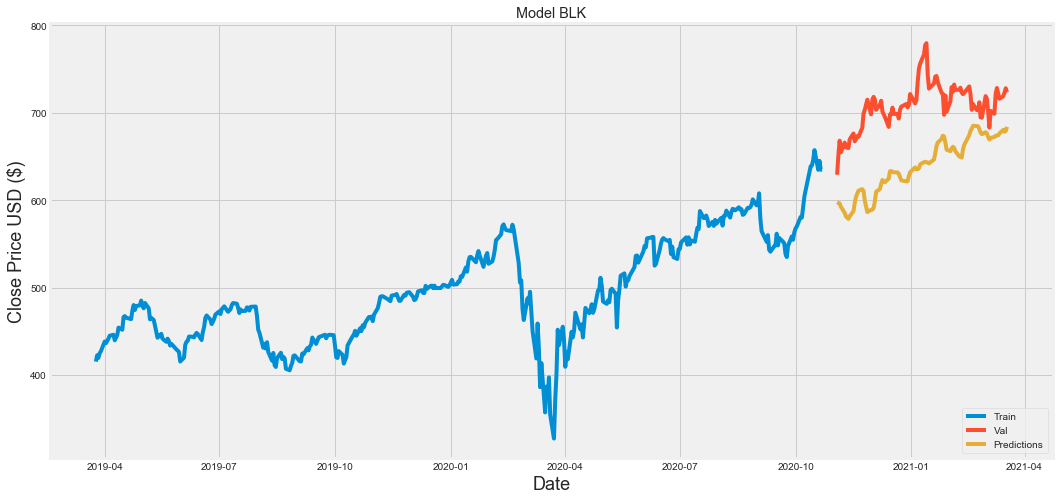

LSTM target is:  Close
LSTM features are:  ['Close', '2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi', 'Sector_Close']
lookback is:  3
lookahead is:  7
years_window is:  2
length of test window:  102
normalization method:  min_max


c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


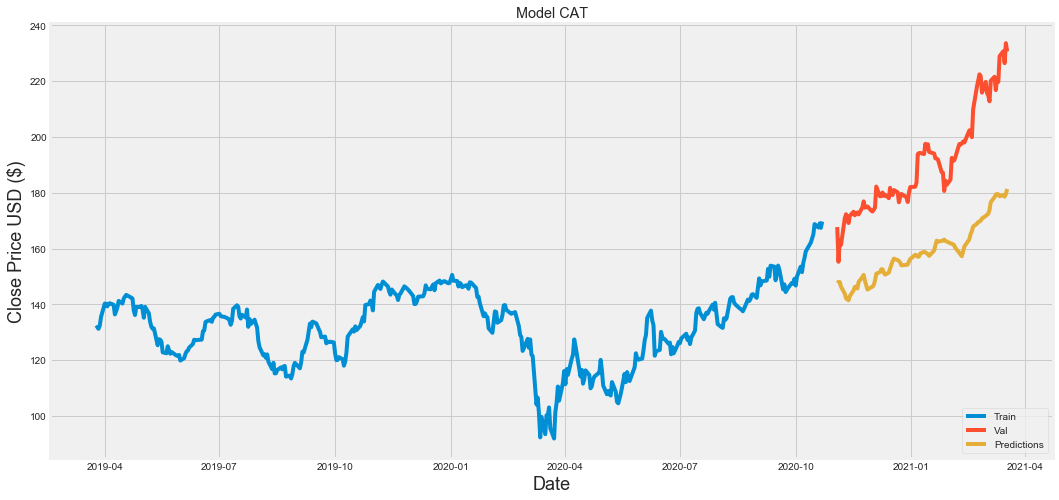

LSTM target is:  Close
LSTM features are:  ['Close', '2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi', 'Sector_Close']
lookback is:  3
lookahead is:  7
years_window is:  2
length of test window:  102
normalization method:  min_max
output table:  C:\personal\karma_stocks_2021\stock_investigation\output\summary20210325-224637.csv
 
Notebook execution duration:  0:00:45.772969
normalized stats
  ticker  total deviation  avg deviation  max deviation  min deviation  \
0    BLK             92.0        68.8520         1.9781         0.1989   
1    CAT             92.0        32.2342         1.6789         0.2239   

  proportion good days  
0                 0.0%  
1                 0.0%  


In [1379]:
# Plot the data

summary_df = pd.DataFrame(columns=['ticker','total deviation','avg deviation','max deviation','min deviation','proportion good days'])
for company in tech_list:
    summary_dict = {}
    train = data[company][:training_data_len]
    #valid = data[company][training_data_len:]
    valid = data[company][training_data_len+look_ahead:]
    #train = np.reshape(train,(train.shape[0],1))
    #valid = np.reshape(valid,(valid.shape[0],1))
    #print("train shape ",train.shape)
    #print("valid shape ",valid.shape)
    #print("predictions[company] shape ",predictions[company].shape)
    #print("things you want ",str(predictions[company].shape[0]-look_ahead))
    valid['Predictions'] = predictions[company][:predictions[company].shape[0]-look_ahead]
    # Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Model'+" "+company)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(lstm_target+' Price USD ($)', fontsize=18)
    plt.plot(train[lstm_target])
    plt.plot(valid[[lstm_target, 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()
    print("LSTM target is: ",lstm_target)
    print("LSTM features are: ",lstm_feature_list)
    print("lookback is: ",str(look_back))
    print("lookahead is: ",str(look_ahead))
    print("years_window is: ",str(years_window))
    print("length of test window: ",len(test_data))
    if min_max_norm:
        norm = "min_max"
    else:
        norm = "standardization"
    print("normalization method: ",norm)
    # df[df > 1.0].count()
    # ['ticker','total error','avg error','max error','proportion good days']
    valid['error'] = valid[lstm_target] - valid['Predictions']
    summary_dict['ticker'] = company
    average_cost = valid['error'].abs().mean()
    summary_dict['total deviation'] = round(valid['error'].abs().sum()/average_cost,report_round)
    summary_dict['avg deviation'] = round(valid['error'].abs().mean(),report_round)
    summary_dict['max deviation'] = round(valid['error'].abs().max()/average_cost,report_round)
    summary_dict['min deviation'] = round(valid['error'].abs().min()/average_cost,report_round)
    summary_dict['proportion good days'] = str(round((valid['error'][valid['error'].abs()/average_cost <= close_threshold].count()/predictions[company].shape[0])*100,2))+'%'
    summary_df = summary_df.append(summary_dict , ignore_index=True)
    # df['var3'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['var3']], index = df.index)
    #summary_df['proportion good days'] = pd.Series(["{0:.2f}%".format(val) for val in summary_df['proportion good days']],index=summary_df.index)
str_date = datetime.now().strftime("%Y%m%d-%H%M%S")
file_name = os.path.join(get_path(),"summary"+str_date+".csv")
print("output table: ",file_name)
summary_df.to_csv(file_name,index=False)
print(" ")
print("Notebook execution duration: ",str(datetime.now() - start_timestamp))
print("normalized stats")
print(summary_df)

In [1380]:
#
# total deviation = sum of difference between actual price and prediction, normalized by average cost
# avg deviation = average difference between actual price and prediction
# max deviation = highest difference between actual price and prediction, normalized by average cost
# proportion good days = proportion of days where difference between actual price and prediction (normalized by avg cost)
# was less than close_threshold value in config file

summary_df.head()

,ticker,total deviation,avg deviation,max deviation,min deviation,proportion good days
0,BLK,92.0,68.8520,1.9781,0.1989,0.0%
1,CAT,92.0,32.2342,1.6789,0.2239,0.0%
